In [295]:
import pandas as pd
from math import log
import numpy as np
from scipy.stats import beta, t, bernoulli, norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [296]:
df = pd.read_csv('framingham_heart_disease.csv')

# Part A

# Hypothesis question:
## Third Experimental question - Does BMI (X) change between gender (Y)

## Question 1

In [297]:
df_observed = df.dropna().sample(n=100, random_state=1)
df_old_observation = df.drop(df_observed.index).dropna().sample(n=1000, random_state=1)

## Question 2 a

Let's define $\tau$ as the median of the bmi, and j=1 as male and j=2 as female

In [298]:
tau = df_observed["BMI"].median()
print(f'tau={tau}')

tau=24.915


As we seen in class, the MLE estimator of $\psi$ is $log(\frac{(n - {X^{2}_{\tau}}){X^{1}_{\tau}}}{(m - {X^{1}_{\tau}}){X^{2}_{\tau}}})$ where:<br> m is number of males,<br> n is number of females,<br> $X^{1}_{\tau}=\sum_{i=1}^{m}I\{x_{i}^1>\tau\}$,<br> $X^{2}_{\tau}=\sum_{i=1}^{n}I\{x_{i}^{2}>\tau\}$.

In [299]:
def calcualte_phi_mle(temp_df, tau):
    x_1 = len(temp_df[(temp_df["male"] == 1) & (temp_df["BMI"] > tau)])
    x_2 = len(temp_df[(temp_df["male"] == 0) & (temp_df["BMI"] > tau)])
    m = len(temp_df[temp_df["male"] == 1])
    n = len(temp_df[temp_df["male"] == 0])
    phi = log((x_1*(n - x_2))/(x_2)*(m- x_1))
    return phi, n, m

In [300]:
phi, n, m = calcualte_phi_mle(df_observed, tau)

In [301]:
print(f"Number of male: {n}, number of female: {m}. MLE estimation of Phi: {np.around(phi,2)}")

Number of male: 53, number of female: 47. MLE estimation of Phi: 6.56


We can see that the log odd ratio is bigger than zero, from that we can infer that the males BMI are more likely to be bigger than $\tau$ compared to females BMI.

Let's find the confident interval of $\psi$ using (quantile) Bootsrap

In [302]:
B = 500
alpha = 0.05
quantile_list = []
for _ in range(B):
    temp_df = df_observed.sample(n=len(df_observed), replace=True)
    phi, _, _ = calcualte_phi_mle(temp_df, tau)
    quantile_list.append(phi)
a = np.quantile(quantile_list, q=(alpha/2))
b = np.quantile(quantile_list, q=(1-(alpha/2)))
print(f"The confident interval is: [{np.around(a, 2)}, {np.around(b,2)}]")

The confident interval is: [5.89, 7.31]


And indeed, the MLE estimator that we just calculated is inside the interval. Moreover, we can see that the confident interval is short and informative, it suggest that the BMI of male is more likely to be above $\tau$ than BMI of females.

## Question 2 b

We will assume that: <br> $\pi(p_1)=1I\{0\le{p_1}\le1\}$, <br> $\pi(p_2)=1I\{0\le{p_2}\le1\}$ <br> ${\mathcal{L}}_m(p_1)={p_1}^{X^{1}_{\tau}}{(1-p_1)}^{m-X^{1}_{\tau}}$ <br> ${\mathcal{L}}_n(p_2)={p_2}^{X^{2}_{\tau}}{(1-p_2)}^{n-X^{2}_{\tau}}$ <br> and as we seen in lecture the postriors are: <br> $p1|X^1\sim{Beta(X^{1}_{\tau} + 1, m - X^{1}_{\tau} +1)}$ <br> $p2|X^2\sim{Beta(X^{2}_{\tau} + 1, n - X^{2}_{\tau} +1)}$<br> We will compute the estimator using simulation by sampling $p_1$ and $p_2$ from their aposterior distributions, and average the simulated phi.

In [303]:
def simulate_p_beta(x_1, x_2, m, n, jeffery=False):
    a1 = x_1 + 0.5 if jeffery else x_1 + 1
    b1 = m - x_1 + 0.5 if jeffery else m - x_1 + 1
    a2 = x_2 + 0.5 if jeffery else x_2 + 1 
    b2 = n - x_2 + 0.5 if jeffery else  n - x_2 + 1
    return beta.rvs(a1, b1), beta.rvs(a2, b2)

In [304]:
B = 10000
phi_list = []
x_1 = len(df_observed[(df_observed["male"] == 1) & (df_observed["BMI"] > tau)]["BMI"])
x_2 = len(df_observed[(df_observed["male"] ==0) & (df_observed["BMI"] > tau)]["BMI"])
m = len(df_observed[df_observed["male"] == 1])
n = len(df_observed[df_observed["male"] == 0])
for _ in range(B):
    p1, p2 = simulate_p_beta(x_1, x_2, m, n)
    phi_flat = logit(p1) - logit(p2)
    phi_list.append(phi_flat)
phi_e = sum(phi_list)/len(phi_list)
a = np.quantile(phi_list, q=(alpha/2))
b = np.quantile(phi_list, q=(1-(alpha/2)))
print(f"The estimator of OR is: {np.around(phi_e, 2)}")
print(f"The credible interval is: [{np.around(a, 2), np.around(b, 2)}]")

The estimator of OR is: 0.55
The credible interval is: [(-0.23, 1.34)]


As we excpect, the odds that men BMI will be above tau is bigger than the odds that women will.<br>
With that being said, we can see that the estimator is much closer to zero and the credible interval is not very informative since it is big and contains zero. This could indicate that the prior we chose might be wrong or that there is no evidence for stochastical differences between the distributions.

## Question 2 c

Now we will assume:<br>
$Z_1^1,...,Z_m^1 \sim Bernouli(p_1)$<br>
$Z_1^2,...,Z_n^2 \sim Bernouli(p_2)$ where:<br>
m is number of males,<br>
n is number of females.<br>
We saw in the lecture that $\pi(p_j)=\sqrt{\frac{1}{p_j(1-p)j)}}$ for j=1,2. <br>
Using these priors we get that the aposteriors distributions of $p_1 \ and \ p_2$ are:<br>
$p1|X^1\sim{Beta(X^{1}_{\tau} + 0.5, m - X^{1}_{\tau} +0.5)}$ <br>
$p2|X^2\sim{Beta(X^{2}_{\tau} + 0.5, n - X^{2}_{\tau} +0.5)}$

In [305]:
B = 10000
phi_jefferys_list = []
for _ in range(B):
    p1, p2 = simulate_p_beta(x_1, x_2, m, n, True)
    phi_jefferys = logit(p1) - logit(p2)
    phi_jefferys_list.append(phi_jefferys)
phi_jefferys_e = sum(phi_jefferys_list)/len(phi_jefferys_list)
a = np.quantile(phi_jefferys_list, q=(alpha/2))
b = np.quantile(phi_jefferys_list, q=(1-(alpha/2)))
print(f"The estimator of OR is: {np.around(phi_jefferys_e, 2)}")
print(f"The credible interval is: [{np.around(a, 2), np.around(b, 2)}]")

The estimator of OR is: 0.57
The credible interval is: [(-0.23, 1.37)]


## Question 2 d

Assuming that now both $p_1 \ and \ p_2$ have priors in the form of Beta distribution and also assuming $Z_i^j \sim Bernouli(p_j)$, we get that the aposterior distributions are: <br>
$p1|X^1, X^1_{old} \sim{Beta(X^{1}_{\tau} + \alpha_1, m - X^{1}_{\tau} + \beta_1)}$ <br>
$p2|X^2, X^2_{old} \sim{Beta(X^{2}_{\tau} + \alpha_2, n - X^{2}_{\tau} + \beta_2)}$

In [306]:
male_z = df_old_observation[df_old_observation['male'] == 1][['BMI']]
female_z = df_old_observation[df_old_observation['male'] == 0][['BMI']]

In [307]:
male_z['Z'] = male_z[['BMI']].apply(lambda x: x>tau)
female_z['Z'] = female_z[['BMI']].apply(lambda x: x>tau)

In [308]:
male_alpha, male_beta = beta.fit(male_z['Z'])[:2]
female_alpha, female_beta = beta.fit(female_z['Z'])[:2]

In [309]:
print(f"The parameteres for p1 are: alpha={np.around(male_alpha, 2)}, beta={np.around(male_beta, 2)}.\nThe parameteres for p2 are: alpha={np.around(female_alpha, 2)}, beta={np.around(female_beta, 2)}.")

The parameteres for p1 are: alpha=1.48, beta=0.62.
The parameteres for p2 are: alpha=1.46, beta=0.92.


In [310]:
B = 10000
phi_old_data_list = []
for _ in range(B):
    p1, p2 = beta.rvs(male_alpha + x_1,m - x_1 + male_beta), beta.rvs(x_2 + female_alpha,n- x_2 + female_beta)
    phi_old_data = logit(p1) - logit(p2)
    phi_old_data_list.append(phi_old_data)
phi_old_data_e = sum(phi_old_data_list)/len(phi_old_data_list)
a = np.quantile(phi_old_data_list, q=(alpha/2))
b = np.quantile(phi_old_data_list, q=(1-(alpha/2)))
print(f"The estimator of OR is: {np.around(phi_old_data_e, 2)}")
print(f"The credible interval is: [{np.around(a, 2), np.around(b, 2)}]")

The estimator of OR is: 0.57
The credible interval is: [(-0.2, 1.38)]


## Question 2 e

In [311]:
print(f"Comparing all estimators for phi:\nphi based on MLE={np.around(phi, 2)},\nphi based on flat priors={np.around(phi_e, 2)},\nphi based on Jefferys' prior={np.around(phi_jefferys_e, 2)},\nphi based on old data and beta prior={np.around(phi_old_data_e, 2)}.")

Comparing all estimators for phi:
phi based on MLE=6.55,
phi based on flat priors=0.55,
phi based on Jefferys' prior=0.57,
phi based on old data and beta prior=0.57.


As we can see, MLE got us the highest phi estimation by far. Moreover, we can see that all estimators agree that the odds of males BMI being larger than $\tau$ are greater than the odds of females BMI to pass it. <br>
However, as we saw in previous sections, the credible intervals for all methods other than MLE are quite large and include zero so it might be not informative enough. <br>
Since MLE doesn't assume any prior over $p_1 \ and \ p_2$ it might be better to go with it and say confidently that the odds are in favour of males BMI. <br>
In addition, comparing between flat, Jefferys' and Beta priors over $p_1 \ and \ p_2$ we can see that the flat and Jefferys' priors achieved quite the same estimators while Beta prior achieved an estimator closer to 1. <br>
This could be a result of relying on old data and some knowledge over the parameters which is more informative yet biased than the priors that try to be non-informative.

# Part B

For this part we'll choose the following paramaters - 
3 explaining paramaters :
* heartRate - numerical variable indicating this person's heart rate per minute.
* cigsPerDay - numerical variable indicating how many cigarates the person is smoking if at all.
* BMI - numerical variable indicating this person's BMI. <br> <br>

and explained paramater : <br>
* totChol - numerical variable indicating total amount of cholesterol in this person's blood (mg/dL).

## Question 1

In [312]:
df_part_b = df.dropna().sample(n=1000, random_state=1, replace=False)

<AxesSubplot:title={'center':'total cholesterol'}, xlabel='mg/dL', ylabel='Number of pepole'>

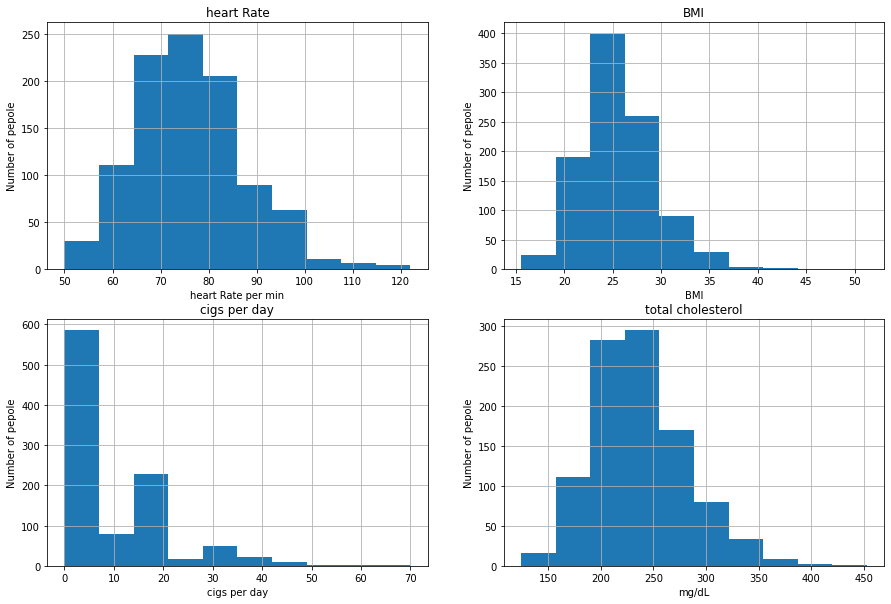

In [313]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title("heart Rate")
axes[0][0].set_xlabel("heart Rate per min")
axes[0][0].set_ylabel("Number of pepole")
df_part_b["heartRate"].hist(ax=axes[0][0])
axes[1][0].set_title("cigs per day")
axes[1][0].set_xlabel("cigs per day")
axes[1][0].set_ylabel("Number of pepole")
df_part_b["cigsPerDay"].hist(ax=axes[1][0])
axes[0][1].set_title("BMI")
axes[0][1].set_xlabel("BMI")
axes[0][1].set_ylabel("Number of pepole")
df_part_b["BMI"].hist(ax=axes[0][1])
axes[1][1].set_title("total cholesterol")
axes[1][1].set_xlabel("mg/dL")
axes[1][1].set_ylabel("Number of pepole")
df_part_b["totChol"].hist(ax=axes[1][1])

In [ ]:
We can see that the 

## Question 2

In [314]:
X = sm.add_constant(df_part_b[["heartRate", "BMI", "cigsPerDay"]])
Y = df_part_b["totChol"]
model = sm.OLS(Y,X)
results = model.fit()
original_OLS_estimators = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                totChol   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.578
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           0.000853
Time:                        11:52:58   Log-Likelihood:                -5205.5
No. Observations:                1000   AIC:                         1.042e+04
Df Residuals:                     996   BIC:                         1.044e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.5730     12.412     15.113      0.000     163.217     211.929
heartRate      0.2787      0.120      2.328      0.020       0.044       0.514
BMI            1.1046      0.357      3.091      0.002       0.403       1.806
cigsPerDay    -0.0161      0.119     -0.136      0.892      -0.249       0.217
==============================================================================
Omnibus:                       70.541   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.183
Skew:                           0.632   Prob(JB):                     7.10e-20
Kurtosis:                       3.722   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [315]:
def calc_ci(x, y, y_pred, params, quantile):
    sigma = (((y - y_pred).T@(y - y_pred))/(len(y) - x.shape[1]))
    c = np.linalg.inv(x.T@x)
    ci = []
    for i in range(x.shape[1]):
        a = params[i] - quantile*(c[i][i]*sigma)**0.5
        b = params[i] + quantile*(c[i][i]*sigma)**0.5
        ci.append((a, b))
    return ci

In [316]:
t_q = t.ppf(0.975, df=3)
original_OLS_ci = calc_ci(X, Y, results.predict(), results.params, t_q)
for i, (a, b) in enumerate(original_OLS_ci):
    print(f"confident interval for paramater: {results.params.index[i]} is ({np.around(a, 2)}, {np.around(b, 2)})")

confident interval for paramater: const is (148.07, 227.07)
confident interval for paramater: heartRate is (-0.1, 0.66)
confident interval for paramater: BMI is (-0.03, 2.24)
confident interval for paramater: cigsPerDay is (-0.39, 0.36)


## Question 3

In [317]:
Y_sorted = Y.sort_values()
n = len(Y_sorted)
remove_indices = []
for i, index in enumerate(reversed(Y_sorted.index)):
    reversed_i = n - (i)
    p_i = (reversed_i)/(2+reversed_i)
    if bernoulli.rvs(p_i):
        remove_indices.append(index)
    if len(remove_indices) == 500:
        break

## Question 4

### Question 4 a

In [318]:
Y_observed = Y.drop(index=remove_indices)
X_observed = X.drop(index=remove_indices)

In [319]:
model_missing_data = sm.OLS(Y_observed,X_observed)
results_missing_data = model_missing_data.fit()
a_OLS_estimators = results_missing_data.params
results_missing_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                totChol   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.966
Date:                Fri, 28 Jan 2022   Prob (F-statistic):             0.0317
Time:                        11:52:58   Log-Likelihood:                -2237.0
No. Observations:                 500   AIC:                             4482.
Df Residuals:                     496   BIC:                             4499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.6294      8.050     24.798      0.000     183.813     215.446
heartRate     -0.1544      0.084     -1.840      0.066      -0.319       0.010
BMI            0.5778      0.232      2.491      0.013       0.122       1.034
cigsPerDay    -0.0166      0.080     -0.208      0.836      -0.174       0.141
==============================================================================
Omnibus:                       29.288   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.870
Skew:                          -0.618   Prob(JB):                     7.28e-08
Kurtosis:                       3.224   Cond. No.                         679.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [320]:
a_OLS_ci = calc_ci(X_observed, Y_observed, results_missing_data.predict(), results_missing_data.params, t_q)
for i, (a, b) in enumerate(a_OLS_ci):
    print(f"confidence interval for paramater with missing data: {results_missing_data.params.index[i]} is ({np.around(a, 2)}, {np.around(b, 2)})")

confidence interval for paramater with missing data: const is (174.01, 225.25)
confidence interval for paramater with missing data: heartRate is (-0.42, 0.11)
confidence interval for paramater with missing data: BMI is (-0.16, 1.32)
confidence interval for paramater with missing data: cigsPerDay is (-0.27, 0.24)


### Question 4 b

In [321]:
X_missing_data = X[X.index.isin(remove_indices)]
Y_missing_data = Y[Y.index.isin(remove_indices)]
Y_missing_predictions = results_missing_data.predict(X_missing_data)

In [322]:
Y_imputed = pd.concat([Y_observed, Y_missing_predictions])
X_imputed = pd.concat([X_observed, X_missing_data])

In [323]:
model_imputed = sm.OLS(Y_imputed,X_imputed)
results_imputed = model_imputed.fit()
b_OLS_estimators = results_imputed.params
results_imputed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     11.71
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           1.52e-07
Time:                        11:52:58   Log-Likelihood:                -4127.5
No. Observations:                1000   AIC:                             8263.
Df Residuals:                     996   BIC:                             8283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.6294      4.223     47.268      0.000     191.342     207.917
heartRate     -0.1544      0.041     -3.792      0.000      -0.234      -0.075
BMI            0.5778      0.122      4.753      0.000       0.339       0.816
cigsPerDay    -0.0166      0.040     -0.411      0.681      -0.096       0.063
==============================================================================
Omnibus:                      184.088   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.730
Skew:                          -0.874   Prob(JB):                    5.97e-136
Kurtosis:                       6.448   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [324]:
b_OLS_ci = calc_ci(X_imputed, Y_imputed, results_imputed.predict(), results_imputed.params, t_q)
for i, (a, b) in enumerate(b_OLS_ci):
    print(f"confidence interval for paramater with regresssion imputation: {results_imputed.params.index[i]} is ({np.around(a, 2)}, {np.around(b, 2)})")

confidence interval for paramater with regresssion imputation: const is (186.19, 213.07)
confidence interval for paramater with regresssion imputation: heartRate is (-0.28, -0.02)
confidence interval for paramater with regresssion imputation: BMI is (0.19, 0.96)
confidence interval for paramater with regresssion imputation: cigsPerDay is (-0.15, 0.11)


### Question 4 c + d

In [325]:
sigma = ((results_missing_data.resid.values.T@results_missing_data.resid.values)/(len(Y_observed) - X_observed.shape[1]))**0.5
M = 50
X_M = []
Y_M = []
for i in range(M):
    X_i = pd.concat([X_observed, X_missing_data])
    Y_i = []
    mus = results_missing_data.predict(X_missing_data)
    for mu in mus.values:
        Y_M_pred = norm.rvs(loc=mu, scale=sigma)
        Y_i.append(Y_M_pred)
    Y_i = np.concatenate([Y_observed, Y_i])
    X_M.append(X_i)
    Y_M.append(Y_i)

In [326]:
b_params = []
b_params_names = ["const", "heartRate", "BMI", "cigsPerDay"]
cov_matrix = np.linalg.inv(X_M[0].T@X_M[0])
var_matrices = []
for X_i, Y_i in zip(X_M, Y_M):
    model_multi_imputed = sm.OLS(Y_i,X_i)
    results_multi_imputed = model_multi_imputed.fit()
    sigma = (results_multi_imputed.resid.values.T@results_multi_imputed.resid.values)/(len(Y_i) - X_i.shape[1])
    var_matrices.append(sigma*cov_matrix)
    b_params.append(results_multi_imputed.params.values)

In [327]:
c_OLS_estimators = np.mean(b_params, axis=0)
for param_name, value in zip(b_params_names, estimated_params):
    print(f"The paramaters estimator using MI for {param_name}, is {np.around(value, 2)}")
c_OLS_estimators = pd.Series(data=np.mean(b_params, axis=0), index=[b_params_names])

The paramaters estimator using MI for const, is 195.84
The paramaters estimator using MI for heartRate, is -0.09
The paramaters estimator using MI for BMI, is 0.53
The paramaters estimator using MI for cigsPerDay, is -0.03


In [328]:
def calc_robin_se(M, M_params: list, MI_params: np.array, var_matrices: list):
    coefficient = (M+1)/(M*(M-1))
    params_var = [0]*MI_params.shape[0]
    params_se = []
    for m in range(M):
        for i in range(MI_params.shape[0]):
            params_var[i] += (1/(var_matrices[m][i][i]))/M + coefficient*(M_params[m][i] - MI_params[i])**2
    for i in range(MI_params.shape[0]):
        params_se.append(np.sqrt(params_var[i]))
    return params_se

In [329]:
params_se = calc_robin_se(M, b_params, estimated_params, var_matrices)

In [330]:
c_OLS_ci = []
for i in range(estimated_params.shape[0]):
    a = estimated_params[i] - t_q*params_se[i]*(cov_matrix[i][i])**0.5
    b = estimated_params[i] + t_q*params_se[i]*(cov_matrix[i][i])**0.5
    c_OLS_ci.append((a, b))
    print(f"confidence interval for paramater with multiple imputation: {b_params_names[i]} is ({np.around(a, 2)}, {np.around(b, 2)})")

confidence interval for paramater with multiple imputation: const is (190.91, 200.76)
confidence interval for paramater with multiple imputation: heartRate is (-0.24, 0.06)
confidence interval for paramater with multiple imputation: BMI is (0.39, 0.68)
confidence interval for paramater with multiple imputation: cigsPerDay is (-0.18, 0.12)


### Question 4 e

In [331]:
X_R = X.index.isin(remove_indices)

In [332]:
clf = LogisticRegression(random_state=0).fit(X, X_R)

In [333]:
pi_1 = clf.predict_proba(X).T[1]

In [334]:
pi_1

array([0.69616305, 0.47540939, 0.43783335, 0.57846697, 0.50193574,
       0.5300777 , 0.47598834, 0.47935516, 0.50009974, 0.43868248,
       0.49616064, 0.52507444, 0.46079118, 0.61311907, 0.52444545,
       0.5640638 , 0.42566533, 0.49354602, 0.50123658, 0.60172409,
       0.54460168, 0.47314167, 0.41099122, 0.55320142, 0.47248078,
       0.49494042, 0.46169785, 0.47534829, 0.58667313, 0.44120122,
       0.43872816, 0.47794266, 0.47206739, 0.4034293 , 0.65359917,
       0.47565181, 0.4707246 , 0.4308365 , 0.47805936, 0.59439691,
       0.3841562 , 0.47433078, 0.48560279, 0.53104203, 0.43506356,
       0.5877357 , 0.43442547, 0.54905395, 0.51539685, 0.42075989,
       0.52384035, 0.47096194, 0.53919309, 0.46981991, 0.51473907,
       0.52143444, 0.48025312, 0.48443735, 0.40685114, 0.50476566,
       0.50238075, 0.47777055, 0.41126965, 0.59229734, 0.50566132,
       0.39449803, 0.57318357, 0.43741335, 0.38661755, 0.42417528,
       0.47873486, 0.48355178, 0.56675072, 0.35485681, 0.50731

### Question 4 f

We know that the OLS estimator with no missing data is: <br> 
$\hat{w}=\underset{w}{\arg\min}\frac{1}{n}\sum_{i=1}^{n}(Y_i - w^TX_i)^2$. <br>
With the missing data we will use the IPW estimator: <br>
$\hat{w}=\underset{w}{\arg\min}\frac{1}{n}\sum_{i=1}^{n}\frac{(Y_i - w^TX_i)^2R_i}{\hat{\pi}(X_i)}$<br>
When $\hat{\pi}(X_i)$ is the LR model from the previous section.

In [335]:
def calculate_ipw_estimator(X_ipw, Y_ipw, ipw_weights_observed):
    model = sm.WLS(Y_ipw,X_ipw, weights=ipw_weights_observed)
    results = model.fit()
    return results.params

In [336]:
e_OLS_estimators = calculate_ipw_estimator(X_observed, Y_observed, pi_1[X_R])

In [337]:
for i, p in enumerate(e_OLS_estimators):
    print(f"IPW estimator for {b_params_names[i]} is {np.round(p, 2)}")

IPW estimator for const is 200.23
IPW estimator for heartRate is -0.16
IPW estimator for BMI is 0.55
IPW estimator for cigsPerDay is -0.0


### Question 4 g

Let's use quantile bootstrap method for the confident interval

In [338]:
B = 1000
param_hist = []
bootstrap_data = pd.concat([X_observed, Y_observed], axis=1)
bootstrap_data["weights"] = pi_1[X_R]
for _ in range(B):
    temp_data = bootstrap_data.sample(n=len(bootstrap_data), replace=True)
    X_bootstrap = temp_data[['const', 'heartRate', 'BMI', 'cigsPerDay']]
    Y_bootstrap = temp_data['totChol']
    weights = temp_data['weights']
    param_hist.append(calculate_ipw_estimator(X_bootstrap, Y_bootstrap, weights))

In [339]:
a = np.quantile(param_hist, axis=0, q=0.025)
b = np.quantile(param_hist, axis=0, q=0.925)
e_OLS_ci = list(zip(a, b))
for i, (a_i, b_i) in enumerate(zip(a, b)):
    print(f"IPW confident interval estimator for {b_params_names[i]} is ({np.round(a_i, 2)}, {np.round(b_i, 2)})")

IPW confident interval estimator for const is (182.88, 212.16)
IPW confident interval estimator for heartRate is (-0.32, -0.03)
IPW confident interval estimator for BMI is (0.07, 0.89)
IPW confident interval estimator for cigsPerDay is (-0.15, 0.11)


### Question 4 h

In [340]:
print(f"The original OLS estimators are: \n{original_OLS_estimators}")
print(f"The missing data OLS estimators are: \n{a_OLS_estimators}")
print(f"The regression imputation OLS estimators are: \n{b_OLS_estimators}")
print(f"The multiple ipmutation OLS estimators are: \n{c_OLS_estimators}")
print(f"The IPW OLS estimators are: \n{e_OLS_estimators}")

The original OLS estimators are: 
const         187.573014
heartRate       0.278678
BMI             1.104632
cigsPerDay     -0.016091
dtype: float64
The missing data OLS estimators are: 
const         199.629358
heartRate      -0.154429
BMI             0.577836
cigsPerDay     -0.016606
dtype: float64
The regression imputation OLS estimators are: 
const         199.629358
heartRate      -0.154429
BMI             0.577836
cigsPerDay     -0.016606
dtype: float64
The multiple ipmutation OLS estimators are: 
const         199.097656
heartRate      -0.153337
BMI             0.591932
cigsPerDay     -0.010122
dtype: float64
The IPW OLS estimators are: 
const         200.225185
heartRate      -0.158120
BMI             0.548367
cigsPerDay     -0.002527
dtype: float64


In [341]:
ci_list = [original_OLS_ci, a_OLS_ci, b_OLS_ci, c_OLS_ci, e_OLS_ci]
ci_names = ['Original', 'Missing data', 'regression imputation', 'Multiple imputation', 'IPW']
data_dict = {}
data_dict['beta_i'] = ['beta 0','beta 1','beta 2', 'beta 3']
for (name, li) in zip(ci_names, ci_list):
    data_dict[name+'_lower'] = [x[0] for x in li]
    data_dict[name+'_upper'] = [x[1] for x in li]
ci_df = pd.DataFrame(data_dict)

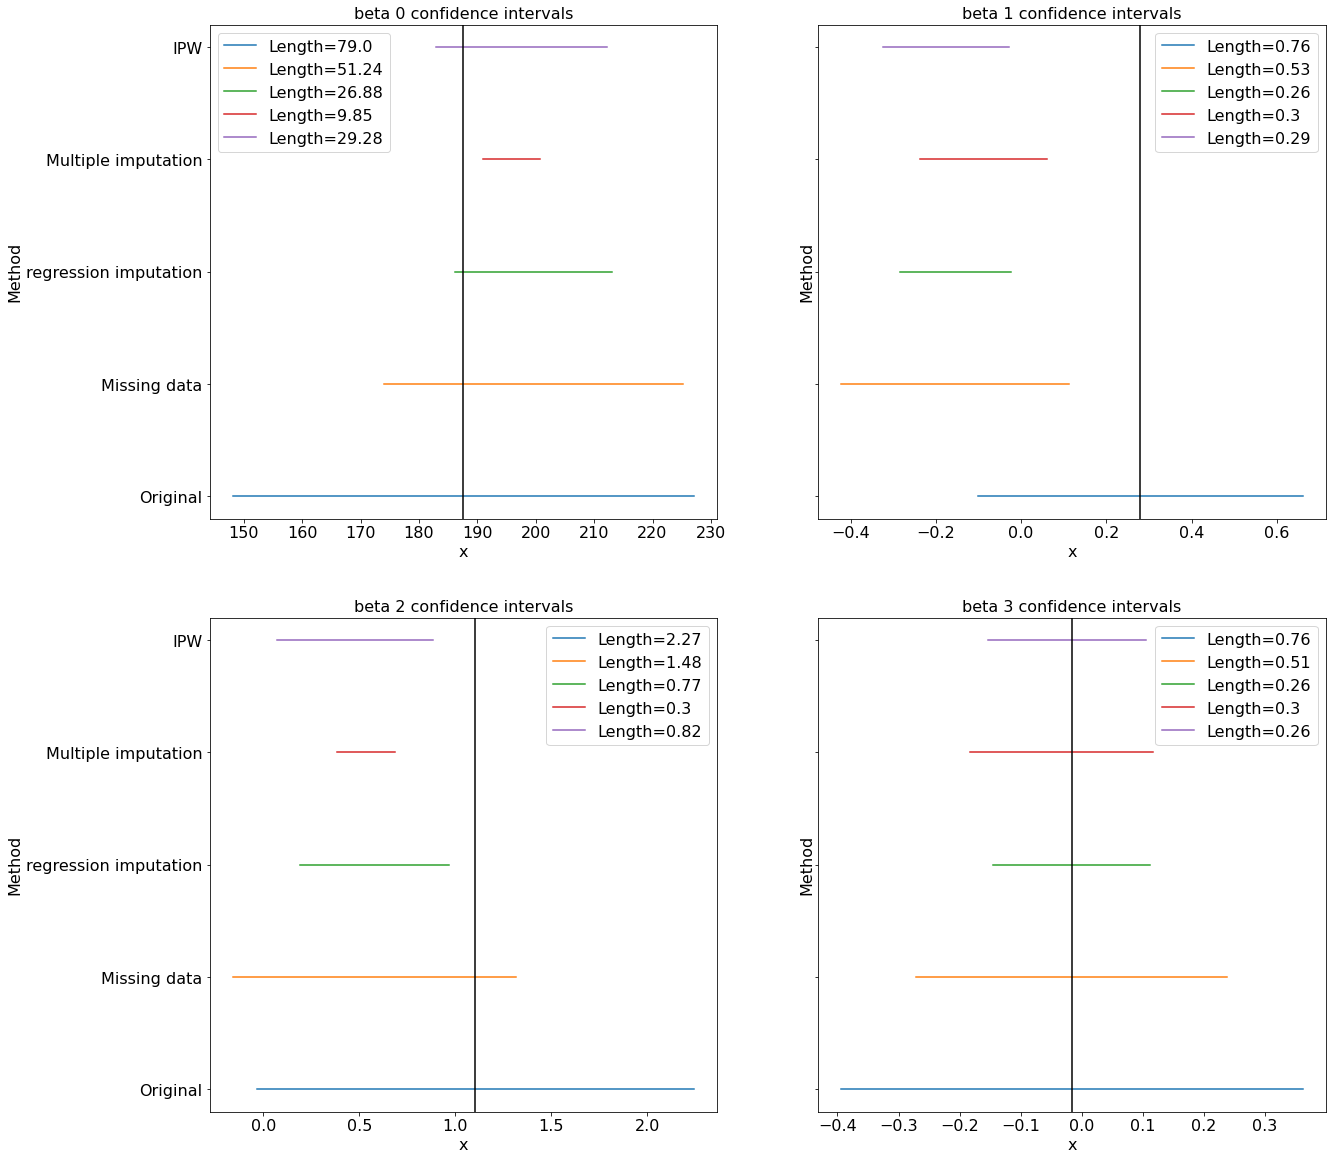

In [342]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(20,20))
row_idx = 0
col_idx = 0
for i, row in ci_df.iterrows():
    for y, ci_name in enumerate(ci_names):
        ax[row_idx][col_idx].plot((row[ci_name+'_lower'], row[ci_name+'_upper']), (y,y), label=f"Length={np.around(row[ci_name+'_upper']-row[ci_name+'_lower'],2)}")
    ax[row_idx][col_idx].set_title(row['beta_i'] + ' confidence intervals', fontsize=16)
    ax[row_idx][col_idx].set_xlabel('x', fontsize=16)
    ax[row_idx][col_idx].set_ylabel('Method', fontsize=16)
    ax[row_idx][col_idx].tick_params(axis='both', which='major', labelsize=16)
    ax[row_idx][col_idx].legend(fontsize=16)
    ax[row_idx][col_idx].axvline(original_OLS_estimators[i], color='black')
    col_idx += 1
    if i%2:
        col_idx = 0
        row_idx += 1
plt.yticks(range(len(ci_names)),ci_names)
plt.show()